In [84]:
%matplotlib notebook
import matplotlib.pyplot as plt

import glob

import pandas
import numpy as np
import itertools
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

# For testing purpose
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier


# Classes:
# 1 - Ground
# 2 - Fly
# 3 - Canopy
# 4 - In aircraft

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km * 1000 # in m

def preprocess_data(df):
    df['time'] = pandas.to_datetime(df['time'])
    df.set_index('time', inplace=True)
    df['h_speed'] = (df['velN']**2 + df['velE']**2) ** 0.5 * 3.6
    df['v_speed'] = df['velD'] * 3.6
    
    return df
    
def smooth_speeds(df):
    freq = 5
    window_size = freq * 3

    df['h_speed'] = signal.savgol_filter(df['h_speed'], window_size, 0, mode='nearest')
    df['v_speed'] = signal.savgol_filter(df['v_speed'], window_size, 0, mode='nearest')

    return df
    
def extract_features(df):
    df['lat_prev'] = df.shift()['lat'].fillna(method='bfill')
    df['lon_prev'] = df.shift()['lon'].fillna(method='bfill')
    df['dist_from_prev'] = haversine_np(df['lat'], df['lon'], df['lat_prev'], df['lon_prev'])
    df['dist'] = df['dist_from_prev'].cumsum()
    df['dist_pct'] = df['dist'] / df['dist'].max()
    df['v_speed_change'] = df['v_speed'].pct_change().fillna(0).abs()
    df['v_speed_change'] = pandas.rolling_median(df['v_speed_change'], window=3, center=True).fillna(0)
    
    return df

def train_dataset():
    directory = glob.glob('./train/*.csv')
    train_files = list()
    for name in directory:
        df = pandas.read_csv(name)
        df = preprocess_data(df)
        df = extract_features(df)
        train_files.append(df)
        
    return pandas.concat(train_files)
   
dataset = train_dataset()
print(dataset.head())

X_train = dataset[['h_speed', 'v_speed', 'v_speed_change']]
# min_max_scaler = StandardScaler()
# X_train = min_max_scaler.fit_transform(X_train)


y_train = dataset['class']

svm_clf = svm.SVC(kernel='rbf', gamma=0.001, C=1.0, decision_function_shape='ovr')
svm_clf.fit(X_train, y_train)



# bdt_real = AdaBoostClassifier(
#     DecisionTreeClassifier(max_depth=5),
#     n_estimators=100,
#     learning_rate=1)
# bdt_real.fit(X_train, y_train)

#neigh = KNeighborsClassifier(n_neighbors=7, weights='distance')
#neigh.fit(X_train, y_train) 


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:69: FutureWarning: pd.rolling_median is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=3,center=True).median()


                              cAcc  class       dist  dist_from_prev  \
time                                                                   
2017-06-17 06:23:17.500  130.43816      1   0.000000        0.000000   
2017-06-17 06:23:17.800  130.43956      1   2.545355        2.545355   
2017-06-17 06:23:18.000  130.44022      1   6.614729        4.069374   
2017-06-17 06:23:18.200   39.01079      1   8.519618        1.904889   
2017-06-17 06:23:18.400   30.75506      1  11.697130        3.177512   

                         dist_pct  gpsFix    hAcc     hMSL   h_speed  \
time                                                                   
2017-06-17 06:23:17.500  0.000000       3  84.596  232.551  6.060950   
2017-06-17 06:23:17.800  0.000032       3  38.584  233.627  4.898382   
2017-06-17 06:23:18.000  0.000082       3  28.369  240.192  3.279361   
2017-06-17 06:23:18.200  0.000106       3  19.267  241.436  5.157558   
2017-06-17 06:23:18.400  0.000146       3  14.399  234.269  5.3

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [86]:
"""
TEST MODEL
"""

from scipy import signal
import json
from dateutil import parser

class_names = ['ground', 'flight', 'canopy', 'aircraft']
    
def predict(df, classifier):
    X_pred = df[['h_speed', 'v_speed', 'v_speed_change']]
    #X_pred = min_max_scaler.fit_transform(X_pred)
    df['class'] = classifier.predict(X_pred)
    
    return df
    
    
def postprocessing(df):
    df['group'] = df['class'].diff().ne(0).cumsum()
    
    grouped = df.groupby('group')['group'].apply(lambda x : x.index)
    
    print(grouped)
    # 1. Convert to list
    result = list()
    for x in grouped:
        values = df.iloc[x]
        first, last = values.iloc[0], values.iloc[-1]
        result.append({
            'type':     first['class'],
            'start':    first['time'],
            'end':      last['time'],
        })
    
    # 2. In case of aircraft-canopy-aircraft - merge into aircraft    
#     for idx, cur_values in enumerate(result):
#         if idx + 2 > len(result) - 1:
#             break
          
#         med_values = result[idx + 1]
#         next_values = result[idx + 2]
            
#         if cur_values['type'] == next_values['type']:
#             cur_values['end'] = next_values['end']
#             result.remove(med_values)
#             result.remove(next_values)
    
#     # 3. Allowed transitions
#     allowed_transitions = [
#         { 'from': 1, 'to': 4 }, # ground -> aircraft
#         { 'from': 1, 'to': 2 }, # ground -> flight
#         { 'from': 4, 'to': 2 }, # aircraft -> flight
#         { 'from': 2, 'to': 3 }, # flight -> canopy
#         { 'from': 3, 'to': 1 }, # canopy -> ground
#     ]
    
#     for idx, cur_values in enumerate(result):
#         if idx + 1 > len(result) - 1:
#             break
            
#         next_values = result[idx + 1]

#         for item in allowed_transitions:
#             if item['from'] == cur_values['type'] and item['to'] == next_values['type']:
#                 break
#         else:
#             cur_values['end'] = next_values['end']
#             result.remove(next_values)
            
#     # 4. Merge duplicates
#     for idx, cur_values in enumerate(result):
#         if idx + 1 > len(result) - 1:
#             break
            
#         next_values = result[idx + 1]

#         if cur_values['type'] == next_values['type']:
#             cur_values['end'] = next_values['end']
#             result.remove(next_values)
            
    return result


def print_prediction(result):
        
    for x in result:
        print(json.dumps({
            'type':     class_mappings[x['type']],
            'duration': str(parser.parse(x['end']) - parser.parse(x['start'])),
            'start':    x['start'],
            'end':      x['end'],
            
        }))

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def show_confusion_matrix(y_test, y_pred):
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')


def process_track(file_name):
    print("\n### ", file_name)
    df = pandas.read_csv('./test/' + file_name)
    df['test_class'] = df['class']
    
    df = preprocess_data(df)
    df = smooth_speeds(df)
    df = extract_features(df)
    df = predict(df, svm_clf)
    
    show_confusion_matrix(df['test_class'], df['class'])
    
    postprocessed = postprocessing(df)
    print_prediction(postprocessed)

process_track('Base Big WS labeled.csv')
process_track('Skydive Med WS 2 labeled.CSV')

plt.show()


###  Base Big WS labeled.csv


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:69: FutureWarning: pd.rolling_median is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=3,center=True).median()


<IPython.core.display.Javascript object>

Normalized confusion matrix
[[  9.93e-01   0.00e+00   9.88e-04   5.93e-03]
 [  1.42e-02   8.91e-01   9.48e-02   0.00e+00]
 [  0.00e+00   0.00e+00   1.00e+00   0.00e+00]
 [       nan        nan        nan        nan]]
group
1    DatetimeIndex([       '2018-01-10 09:06:12', '...
2    DatetimeIndex(['2018-01-10 09:09:13.200000', '...
3    DatetimeIndex(['2018-01-10 09:09:15.400000', '...
4    DatetimeIndex([       '2018-01-10 09:09:53', '...
5    DatetimeIndex(['2018-01-10 09:10:27.800000',  ...
6    DatetimeIndex([       '2018-01-10 09:10:29', '...
Name: group, dtype: object


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide


IndexError: positional indexers are out-of-bounds

<IPython.core.display.Javascript object>


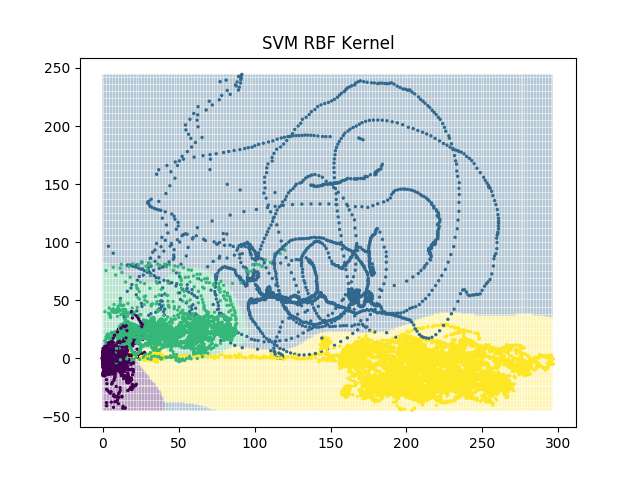

In [58]:
"""
VISUALIZE RESULTS
"""

plt.figure()
plt.scatter(dataset['h_speed'], dataset['v_speed'], c=y, zorder=10, s=2)
#Circle out the test data
#plt.scatter(X_test['h_speed'], X_test['v_speed'], s=80, facecolors='none',
#            zorder=10, edgecolor='k', alpha=0.3)

x_min, x_max = X['h_speed'].min(), X['h_speed'].max()
y_min, y_max = X['v_speed'].min(), X['v_speed'].max()

h = 1
XX, YY = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))


Z = svm_clf.predict(np.c_[XX.ravel(), YY.ravel()]).reshape(XX.shape)
ax = plt.gca()
ax.pcolormesh(XX, YY, Z, alpha = 0.1)

plt.title('SVM RBF Kernel')

plt.show()